In [2]:
#Wilson Loop Calculation
def HamBlk(kx,ky,kz,syst,kwant=False):
    if kwant==True:
        syst = syst(kx,ky,kz)
        syst = syst.finalized()
        ham_mat = syst.hamiltonian_submatrix(sparse=True)
        EV,EVec=np.linalg.eigh(ham_mat.toarray())
    else:
        solver= pb.solver.lapack(syst)
        solver.set_wave_vector([kx,ky,kz])
        EV=solver.eigenvalues
        EVec=solver.eigenvectors
    return EV, EVec
def proj(kx,ky,kz,syst,bnds,kwant=False):
    w,v=HamBlk(kx,ky,kz,syst,kwant)
    #w,v=np.linalg.eigh(H)
    ft=np.zeros(np.shape(np.outer(np.transpose(np.conjugate(v[:,[0]])),v[:,[0]])))
    for i in bnds:
        ft=ft+np.outer(v[:,[i]],np.transpose(np.conjugate(v[:,[i]])))
    return ft
def eig(kx,ky,kz,syst,bnds,kwant):
    w,v=HamBlk(kx,ky,kz,syst,kwant)
    #w,v=np.linalg.eigh(H)
    return v[:,bnds]
def WSurf(vec,syst,bnds,ds,ds2,rvec0,kwant=False):
    #rvec0 = np.array((getattr(syst,'lattice')).reciprocal_vectors())
    rvec=np.zeros((3,3))
    for j in range(np.shape(rvec0)[0]):
        rvec[j]=rvec0[j]
    WCC=[]
    #rf3=np.dot(rvec,vec(0,1))
    #kp = np.linspace(0,rf3,ds2)
    for kk1 in range(int(ds2+1)):
        kk=np.dot(vec(0,kk1/ds2),rvec)
        #rf=np.dot(vec(1,0),rvec)
        #rf2=np.dot(vec(1,0),rvec)+kk
        rf=np.dot(np.array(vec(1,0))-np.array(vec(0,0)),rvec)
        rf2=rf+kk
        kpts=np.linspace(rf/ds+kk,rf-rf/ds+kk,ds)
        w,v=HamBlk(rf2[0],rf2[1],rf2[2],syst,kwant)
        #w,v=np.linalg.eigh(H)
        sp=v[:,bnds]
        ft=proj(rf2[0],rf2[1],rf2[2],syst,bnds,kwant)
        ff=ft
        for i in kpts:
            ft=np.dot(ft,proj(i[0],i[1],i[2],syst,bnds,kwant))
        ft=np.dot(ft,ff)
        WCC.append(np.imag(np.log(np.linalg.eigvals(np.dot(np.dot(np.transpose(np.conjugate(sp)),ft),sp)))))
    return WCC

def projnwl(WCC, bnds2):
    v=np.array(WCC)
    ft=np.zeros(np.shape(np.outer(np.transpose(np.conjugate(v[:,[0]])),v[:,[0]])))
    #ft=np.outer(np.transpose(np.conjugate(v)),v)
    for i in bnds2:
        ft=ft+np.outer(v[:,[i]],np.transpose(np.conjugate(v[:,[i]])))
    return ft
def Hermitize(X):
    return 0.5*(X+np.conjugate(np.transpose(X)))
def WNWL(vec,syst,bnds,bnds2,ds,ds2,rvec0,kwant=False):
    #rvec0 = np.array((getattr(syst,'lattice')).reciprocal_vectors())
    rvec=np.zeros((3,3))
    for j in range(np.shape(rvec0)[0]):
        rvec[j]=rvec0[j]
    WCC=[]
    #rf3=np.dot(vec(0,1),rvec)
    #kp = np.linspace(0,rf3,ds2)
    for kk1 in range(int(ds2+1)):
        kk=np.dot(vec(0,kk1/ds2),rvec)
        #rf=np.dot(vec(1,0),rvec)
        #rf2=np.dot(vec(1,0),rvec)+kk
        rf=np.dot(np.array(vec(1,0))-np.array(vec(0,0)),rvec)
        rf2=rf+kk
        kpts=np.linspace(rf/ds+kk,rf-rf/ds+kk,ds)
        w,v=HamBlk(rf2[0],rf2[1],rf2[2],syst,kwant)
        #w,v=np.linalg.eigh(H)
        sp=v[:,bnds]
        ft=proj(rf2[0],rf2[1],rf2[2],syst,bnds,kwant)
        ff=ft
        for i in kpts:
            ft=np.dot(ft,proj(i[0],i[1],i[2],syst,bnds,kwant))
        ft=np.dot(ft,ff)
        WH=Hermitize(-1j*scipy.linalg.logm(np.dot(np.dot(np.transpose(np.conjugate(sp)),ft),sp)))
        w, v= np.linalg.eigh(WH)
        WCC.append(np.dot(eig(rf2[0],rf2[1],rf2[2],syst,bnds,kwant),v))
    sp=WCC[0][:,bnds2]
    ft=projnwl(WCC[0],bnds2)
    for i in range(int(ds2+1)):
        ft=np.dot(ft,projnwl(WCC[i],bnds2))
    ft=np.dot(ft,projnwl(WCC[0],bnds2))
    return np.imag(np.log(np.linalg.eigvals(np.dot(np.dot(np.transpose(np.conjugate(sp)),ft),sp))))


#Spin resolved Wilson loop:
def proj2(kx,ky,kz,syst,bnds,op,kwant=False):
    H=np.dot(np.dot(proj(kx,ky,kz,syst,bnds,kwant),op),proj(kx,ky,kz,syst,bnds,kwant))
    w,v=np.linalg.eigh(H)
    ft=np.zeros(np.shape(np.outer(np.transpose(np.conjugate(v[:,[0]])),v[:,[0]])))
    for i in bnds[:int(np.shape(bnds)[0]/2)]:
        ft=ft+np.outer(v[:,[i]],np.transpose(np.conjugate(v[:,[i]])))
    return ft
def WSpinSurf(vec,syst,bnds,ds,ds2,op,rvec0,kwant=False):
    #rvec0 = np.array((getattr(syst,'lattice')).reciprocal_vectors())
    rvec=np.zeros((3,3))
    for j in range(np.shape(rvec0)[0]):
        rvec[j]=rvec0[j]
    WCC=[]
    #rf3=np.dot(rvec,vec(0,1))
    #kp = np.linspace(0,rf3,ds2)
    for kk1 in range(int(ds2+1)):
        kk=np.dot(vec(0,kk1/ds2),rvec)
        #rf=np.dot(vec(1,0),rvec)
        #rf2=np.dot(vec(1,0),rvec)+kk
        rf=np.dot(np.array(vec(1,0))-np.array(vec(0,0)),rvec)
        rf2=rf+kk
        kpts=np.linspace(rf/ds+kk,rf-rf/ds+kk,ds)
        H=np.dot(np.dot(proj(rf2[0],rf2[1],rf2[2],syst,bnds[:int(np.shape(bnds)[0]/2)],kwant),op),proj(rf2[0],rf2[1],rf2[2],syst,bnds[:int(np.shape(bnds)[0]/2)],kwant))
        w,v=np.linalg.eigh(H)
        sp=v[:,bnds[:int(np.shape(bnds)[0]/2)]]
        ft=proj2(rf2[0],rf2[1],rf2[2],syst,bnds,op,kwant)
        ff=ft
        for i in kpts:
            ft=np.dot(ft,proj2(i[0],i[1],i[2],syst,bnds,op,kwant))
        ft=np.dot(ft,ff)
        WCC.append(np.imag(np.log(np.linalg.eigvals(np.dot(np.dot(np.transpose(np.conjugate(sp)),ft),sp)))))
    return WCC

def WSpinLine(kpts,syst,bnds,op,kwant=False):
    WCC=[]
    rf2=kpts[0]
    H=np.dot(np.dot(proj(rf2[0],rf2[1],rf2[2],syst,bnds[:int(np.shape(bnds)[0]/2)],kwant),op),proj(rf2[0],rf2[1],rf2[2],syst,bnds[:int(np.shape(bnds)[0]/2)],kwant))
    w,v=np.linalg.eigh(H)
    sp=v[:,bnds[:int(np.shape(bnds)[0]/2)]]
    ft=proj2(rf2[0],rf2[1],rf2[2],syst,bnds,op)
    ff=ft
    for i in kpts[1:]:
        ft=np.dot(ft,proj2(i[0],i[1],i[2],syst,bnds,op))
    ft=np.dot(ft,ff)
    WCC.append(np.imag(np.log(np.linalg.eigvals(np.dot(np.dot(np.transpose(np.conjugate(sp)),ft),sp)))))
    return WCC

def WLine(kpts,syst,bnds,kwant=False):
    WCC=[]
    #rvec0 = np.array(lat.reciprocal_vectors())
    rf2=kpts[0]
    w,v=HamBlk(rf2[0],rf2[1],rf2[2],syst,kwant)
    #w,v=np.linalg.eigh(H)
    sp=v[:,bnds]
    ft=proj(rf2[0],rf2[1],rf2[2],syst,bnds,kwant)
    ff=ft
    for i in kpts[1:]:
        ft=np.dot(ft,proj(i[0],i[1],i[2],syst,bnds,kwant))
    ft=np.dot(ft,ff)
    WCC.append(np.imag(np.log(np.linalg.eigvals(np.dot(np.dot(np.transpose(np.conjugate(sp)),ft),sp)))))
    return WCC
def spin_spectrum(kx,ky,kz,syst,bnds,op,kwant=False):
    H=np.dot(np.dot(proj(kx,ky,kz,syst,bnds,kwant),op),proj(kx,ky,kz,syst,bnds,kwant))
    w, v =np.linalg.eigh(H)
    #w= cp.asnumpy(w)
    #v= cp.asnumpy(v)
    idx = np.argsort(np.abs(w))
    ev = w[idx[int(np.shape(w)[0]-np.shape(bnds)[0]):]]
    return np.sort(ev)

# Interfacing Berry Easy with Kwant

In [1]:
# Packages needed
from BerryEasy import BerryEasy as be
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt
import scipy
import kwant

C:\Users\18585\anaconda3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


# Note that unlike utilizing BerryEasy with PyBinding, the Kwant code requires the user to define the twisted boundary conditions to utilize BerryEasy. 
# Examples of how to implement such boundary conditions are shown here. 


# Define the Chern insulator model in Kwant on a 4x4 slab with twisted boundary conditions tx and ty, such that $\psi(x,y)=e^{i tx}\psi(x+L,y)$ and $\psi(x,y)=e^{i ty}\psi(x,y+L)$

In [2]:

g_1 = np.array([[0, 1],[1,0]])
g_2 = np.array([[0,-1j],[1j,0]])
g_3 = np.array([[1,0],[0,-1]])

def chern_ins(M,tx,ty, a=1, L=4, W=4):

    # square lattice
    lat = kwant.lattice.square(a)
    syst = kwant.Builder()

   

    # onsite potential
    syst[(lat(x, y) for x in range(L) for y in range(W))] = (M - 4) * g_3

    for i in range(L):
        for j in range(W):
            # Hopping along (1,0)
            if i==0:
                syst[lat(i, j), lat((i-1)%L, j)] = (g_3 - 1j * 0.5 * g_1)*np.exp(1j*tx*L) # Defines twisted boundary
            else:
                syst[lat(i, j), lat((i-1)%L, j)] = (g_3 - 1j * 0.5 * g_1)
            # Hopping along (0,1)
            if j==0:
                syst[lat(i, j), lat(i, (j-1)%W)] = (g_3 - 1j * 0.5 * g_2)*np.exp(1j*ty*W) # Defines twisted boundary
            else:
                syst[lat(i, j), lat(i, (j-1)%W)] = (g_3 - 1j * 0.5 * g_2)
            
            
                
                
    return syst

In [3]:
# Compute Wannier center charges along k_{x} direction as a function of transverse momenta k_{y}
L=4

def model(tx,ty,tz):
    return chern_ins(2,tx,ty)


vec=lambda t1, t2: [t1, t2, 0]
ds=100 #discretize integration into 100 steps
ds2=100 #consider 100 points along k_{y}
bnds=range(L*L) #Occupied bands
rvec=2*np.pi*np.diag([1,1,1])/L #Fixed range of twist parameter 
WCCx=be.WSurf(vec,model,bnds,ds,ds2,rvec,kwant=True)

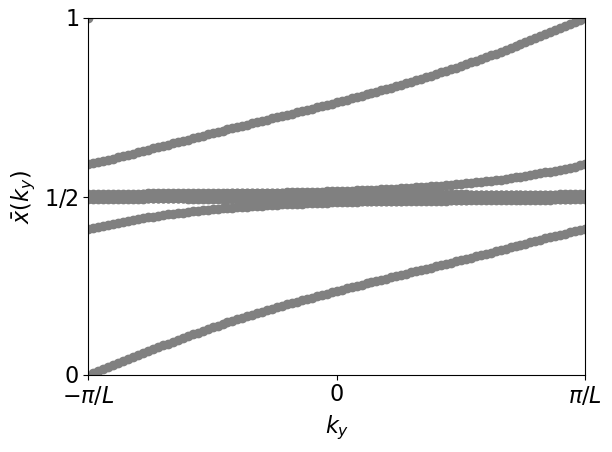

In [4]:
from math import pi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.plot(WCCx,'o', c='gray')
plt.ylim(-pi,pi)
plt.xlim(0,100)
plt.yticks([-pi,0,pi],[r'$0$',r'$1/2$',r'$1$'])
plt.xlabel(r'$k_{y}$')
plt.xticks([0,50,100],[r'$-\pi/L$',r'$0$',r'$\pi/L$'])
plt.ylabel(r'$\bar{x}(k_{y})$')
plt.tight_layout()
#plt.savefig('Kwant_Chern_WCC.png')

plt.show()

# Now let us use the WLine function to compute the Chern number in a reciprocal space resolved manner, summing the Berry curvature through a series of small square plaquettes

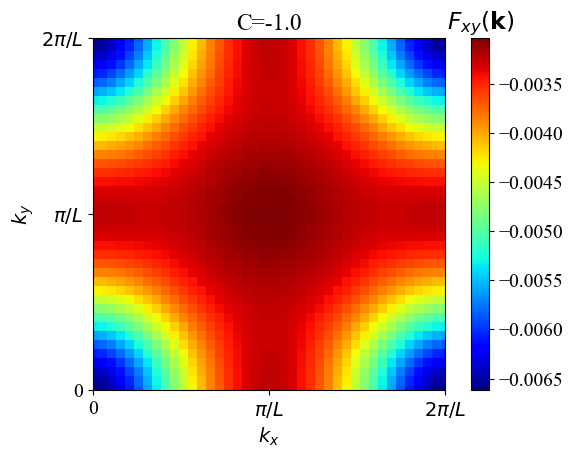

In [6]:
def model(tx,ty,tz):
    return chern_ins(2,tx,ty)
plaquettes=40 #Considering a 40x40 grid for computing Berry flux
rvec1=2*np.pi/L
rvec2=2*np.pi/L
dsx=((np.pi/L)/(plaquettes))
dsy=((np.pi/L)/(plaquettes))
kp1=np.linspace(dsx,rvec1-dsx,plaquettes)
kp2=np.linspace(dsy,rvec2-dsy,plaquettes)
bnds=range(4*4)
WCCtemp=[]
for kx in kp1:
    for ky in kp2:
        kpts=np.array([[kx-dsx,ky-dsy,0],[kx+dsx,ky-dsy,0],[kx+dsx,ky+dsy,0],[kx-dsx,ky+dsy,0]]) # define line for Wilson loop around plaquette
        WCCtemp.append(be.WLine(kpts,model,bnds,kwant=True))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
chern=[]
for j in range(np.shape(WCCtemp)[0]):
    chern.append(np.sum(WCCtemp[j]))
plt.imshow(np.array(chern).reshape(40,40),cmap='jet')
plt.ylabel(r'$k_{y}$')
plt.xlabel(r'$k_{x}$')
plt.xticks([0,19.5,39],[0,'$\pi/L$','$2\pi/L$'])
plt.yticks([0,19.5,39],[0,'$\pi/L$','$2\pi/L$'])
plt.xlim(0,39)
plt.ylim(0,39)

plt.title('C='+str(np.round(np.sum(chern)/(2*np.pi),3)))
clb = plt.colorbar()
clb.ax.set_title(r'$F_{xy}(\mathbf{k})$')
plt.tight_layout()
plt.show()

# Now we consider the BHZ model of a quantum spin-Hall insulator

In [8]:


g_1 = np.array([[0, 0, 0, 1], [0, 0, 1, 0],[0, 1, 0, 0],[1, 0, 0, 0]])
g_2 = np.array([[0,0,0, -1j], [0,0, 1j, 0],[0, -1j,0,0], [1j, 0,0,0]])
g_3 = np.array([[0, 0, 1, 0], [0, 0, 0, -1],[1, 0, 0, 0],[0, -1, 0, 0]])
g_4 = np.array([[0,0, -1j, 0], [0,0, 0,-1j],[1j,0,0,0], [0,1j,0,0]])
g_5 = np.diag([1,1,-1, -1])
def BHZ(M,tx,ty, a=1, L=4, W=4):

    # square lattice
    lat = kwant.lattice.square(a)
    syst = kwant.Builder()
    

    # onsite potential
    syst[(lat(x, y) for x in range(L) for y in range(W))] = (M - 4) * g_5

    for i in range(L):
        for j in range(W):
            # Hopping along (1,0)
            if i==0:
                syst[lat(i, j), lat((i-1)%L, j)] = (g_5 - 1j * 0.5 * g_1)*np.exp(1j*tx*L)
            else:
                syst[lat(i, j), lat((i-1)%L, j)] = (g_5 - 1j * 0.5 * g_1)
            # Hopping along (0,1)
            if j==0:
                syst[lat(i, j), lat(i, (j-1)%W)] = (g_5 - 1j * 0.5 * g_2)*np.exp(1j*ty*W)
            else:
                syst[lat(i, j), lat(i, (j-1)%W)] = (g_5 - 1j * 0.5 * g_2)
            
            
                
                
    return syst

# We compute the WCC spectra to confirm the Z2 classification

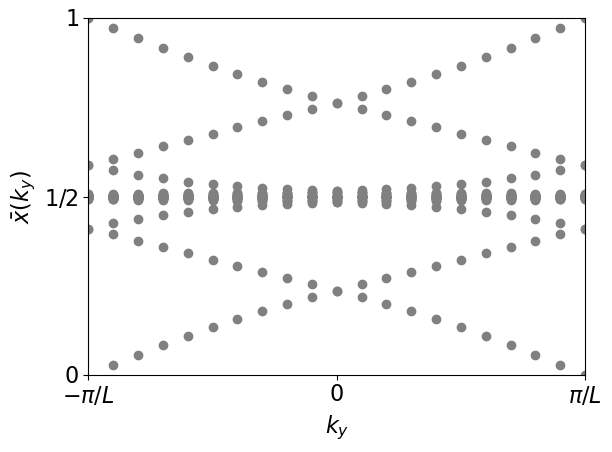

In [9]:
from math import pi
L=4
def model(tx,ty,tz):
    return BHZ(2,tx,ty)
# Compute Wannier center charges along k_{x} direction as a function of transverse momenta
vec=lambda t1, t2: [t1, t2, 0]
ds=20
bnds=range(2*L*L)
rvec=2*np.pi*np.diag([1,1,1])/L
WCCx=be.WSurf(vec,model,bnds,ds,ds,rvec,kwant=True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.plot(WCCx,'o', c='gray')
plt.ylim(-pi,pi)
plt.xlim(0,20)
#plt.xlim(0,100)
plt.yticks([-pi,0,pi],[r'$0$',r'$1/2$',r'$1$'])
plt.xlabel(r'$k_{y}$')
plt.xticks([0,10,20],[r'$-\pi/L$',r'$0$',r'$\pi/L$'])
plt.ylabel(r'$\bar{x}(k_{y})$')
plt.tight_layout()

# Now we consider computing the Nested Wilson loop for the Chiral HOTI Model

In [10]:
from tqdm import tqdm
NWL=[]

ds=20
ds2=40
L=3
bnds=range(2*L*L*L) #bands for construction of Wannier Hamiltonian
bnds2=range(L*L*L) #bands of Wannier Hamiltonian being considered

def CHOTI(tx,ty,tz,a=1, L=3):
    # square lattice
    lat = kwant.lattice.cubic(a)
    syst = kwant.Builder()
    # onsite potential
    syst[(lat(x, y, z) for x in range(L) for y in range(L) for z in range(L))] = (-2.5) * g_5 

    for i in range(L):
        for j in range(L):
            for q in range(L):
                # Hopping along (1,0)
                if i==0:
                    syst[lat(i, j, q), lat((i-1)%L, j, q)] = (.5*g_5 - 1j * 0.5 * g_1+g_4)*np.exp(1j*tx*L)
                else:
                    syst[lat(i, j, q), lat((i-1)%L, j, q)] = (.5*g_5 - 1j * 0.5 * g_1+g_4)
                # Hopping along (0,1)
                if j==0:
                    syst[lat(i, j, q), lat(i, (j-1)%L, q)] = (.5*g_5 - 1j * 0.5 * g_2-g_4)*np.exp(1j*ty*L)
                else:
                    syst[lat(i, j, q), lat(i, (j-1)%L, q)] = (.5*g_5 - 1j * 0.5 * g_2-g_4)      
                if q==0:
                    syst[lat(i, j, q), lat(i, j, (q-1)%L)] = (.5*g_5 - 1j * 0.5 * g_3)*np.exp(1j*tz*L)
                else:
                    syst[lat(i, j, q), lat(i, j, (q-1)%L)] = (.5*g_5 - 1j * 0.5 * g_3)      

    return syst
for kz in tqdm(np.linspace(0,1,21)):
    def model(tx,ty,tz):
        return CHOTI(tx,ty, tz)
    rvec=2*np.pi*np.diag([1,1,1])/L
    vec=lambda t1, t2: [t1, t2, kz]
    WCCx=be.WNWL(vec,model,bnds,bnds2,ds,ds,rvec,kwant=True)
    NWL.append(np.sum(WCCx))

100%|██████████| 21/21 [02:57<00:00,  8.44s/it]


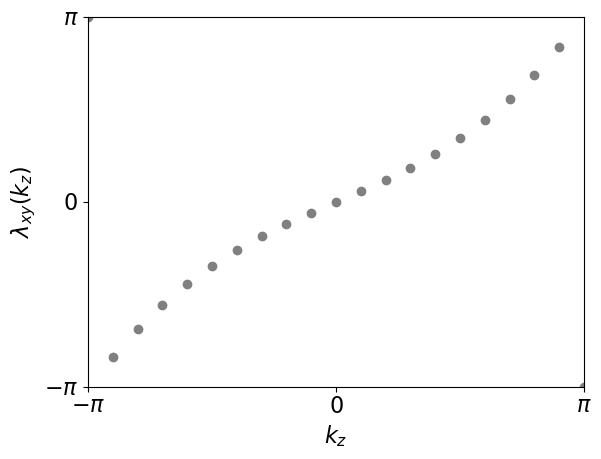

In [11]:
plt.plot(np.array(NWL),'o',c='gray')
plt.ylim(-np.pi,np.pi)
plt.yticks([-np.pi,0,np.pi],[r'$-\pi$',r'$0$',r'$\pi$'])
plt.xlabel(r'$k_{z}$')
plt.xlim(0,20)
plt.xticks([0,10,20],[r'$-\pi$',r'$0$',r'$\pi$'])
plt.ylabel(r'$\lambda_{xy}(k_{z})$')
plt.show()

# Now let us compute the spin-resolved WCC spectra for the Chiral HOTI Model in the kz=0 plane, we will show that using the spin-resolved Wilson loop this plane has a spin-Chern number

In [14]:
def model(tx,ty,tz):
    return CHOTI(tx,ty,tz)
L=3
vec=lambda t1, t2: [t1, t2, 0]
ds=20
ds2=20
bnds=range(2*L*L*L)
S3=np.diag([1,-1])
op=np.kron(np.diag(np.ones(L*L*L)),np.kron(S3,S3)) #Define Preferred Spin axis
rvec=2*np.pi*np.diag([1,1,1])/L
WCCx=be.WSpinSurf(vec,model,bnds,ds,ds2,op,rvec,kwant=True)

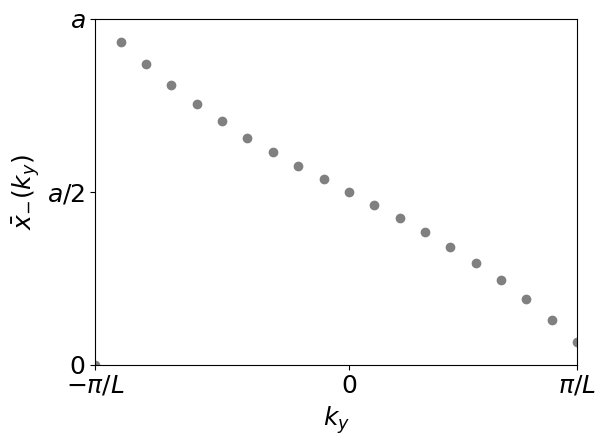

In [15]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
plt.plot(np.sum(WCCx,1),'o', c='gray')
plt.ylim(-pi,pi)
plt.xlim(0,19)
plt.yticks([-pi,0,pi],[r'$0$',r'$a/2$',r'$a$'])
plt.xlabel(r'$k_{y}$')
plt.xticks([0,10,19],[r'$-\pi/L$',r'$0$',r'$\pi/L$'])
plt.ylabel(r'$\bar{x}_{-}(k_{y})$')
plt.tight_layout()
plt.savefig('CH_WCC_SpinWL_Kwant.png')

# Wannier90 compatability coming soon!